# Generating XSS payloads using GANs
*The existing payloads are converted into 16\*16 gray scale images based on their ASCII decimal values. The generative model is then trained on these pixelated vlaues. This was a trial experiment and compared to other generative models like LSTM and GRU the results were not that much promising.* 

In [62]:
# Imports
import os 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    LeakyReLU,
    Dropout,
    Reshape,
    Conv2DTranspose,
    BatchNormalization
)
from keras.utils.vis_utils import plot_model

*Due to the limit of computing power the model was trained on 1000 different payloads from the dataset. The generator model will generate payloads which are not more than 256 characters long.*

In [63]:
# Constants
DATASET_DIR = "datasets"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")
VALIDATION_DIR = os.path.join(DATASET_DIR, "val")
CHECK_POINT_DIR = "checkpoints"
BUFFER_SIZE = 1000
BATCH_SIZE = 256
MAX_SEQUENCE_LENGTH = 256

### Preprocessing 
*The PreprocessPayloads class define four main functions which are used to preprocess and prepare the payloads for training the discriminator model. open_file_and_read_lines function opens a given file and read the payloads. convert_payloads_to_ascii function converts each payloads to their ASCII decimal form on a character level. The pad_payloads function will add 0 at the end of every payload where their length is less than 256, payloads with length greater than 256 are discarded out the dataset. This makes all the payloads have the same length. get_payload_matrix function converts the flat list ASCII representation of a payload into a numpy array with a shape 16X16. Then the matrix is normalized to be in range [-1, 1] which is a prefered way to train the discriminator model*

<class 'numpy.ndarray'> (16, 16) -1.0 -0.09019607843137255


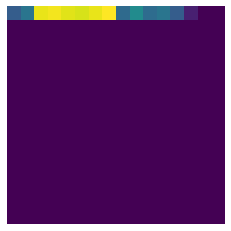

(1000, 16, 16)


In [64]:
class PreprocessPayloads(object):
    def open_payload_file_and_read_lines(self, filename):
        with open(filename, 'r', encoding='utf-8') as file:
            payloads = file.readlines()
        return payloads

    def convert_payloads_to_assci(self, filename):
        payloads = self.open_payload_file_and_read_lines(filename)
        ascii_payloads = []
        for payload in payloads:
            ascii_payloads.append([ ord(c) for c in payload])
        return ascii_payloads

    def pad_payloads(self, filename):
        ascii_payloads = self.convert_payloads_to_assci(filename)
        for payload in ascii_payloads:
            if len(payload) < MAX_SEQUENCE_LENGTH:
                for i in range(MAX_SEQUENCE_LENGTH - len(payload)):
                    payload.append(0.0)
        return ascii_payloads

    def get_payload_matrix(self, filename):
        payloads = self.pad_payloads(filename)
        converted_payloads = []
        for payload in payloads:
            payload = np.asarray(payload)
            payload = np.reshape(payload, (16, 16))
            converted_payloads.append(payload)
        matrix = np.asarray(converted_payloads)
#         matrix = matrix.reshape(matrix.shape + (1,))
        return (matrix - 127.5) / 127.5



preprocess = PreprocessPayloads()
training_images = preprocess.get_payload_matrix(os.path.join(TRAIN_DIR, "training_set.txt"))
print(type(training_images[0]), training_images[0].shape, np.min(training_images[0]), np.max(training_images[0]))
plt.imshow(training_images[0])
plt.axis('off')
plt.show()
print(training_images.shape)


In [65]:
payload = "\"-prompt(8)-\""
for char in payload:
    print(str(ord(char)) + " ", end='')


34 45 112 114 111 109 112 116 40 56 41 45 34 

*generate_real_data function selects data points randomly from our main dataset which will be used to train the discriminator together with label 1 or positive class meaning real data points.*

In [66]:
def load_real_data(filename):
    X = preprocess.get_payload_matrix(os.path.join(TRAIN_DIR, filename))
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X


def generate_real_data(dataset, number_of_samples):
    random_x = np.random.randint(0, dataset.shape[0], number_of_samples)
    X = dataset[random_x]
    y = np.ones((number_of_samples, 1))
    return X, y


def generate_fake_data(number_of_samples):
    X = np.random.rand(16 * 16 * 1 * number_of_samples)
    X = -1 + X * 2
    X = X.reshape((number_of_samples, 16, 16, 1))
    y = np.zeros((number_of_samples, 1))
    return X, y


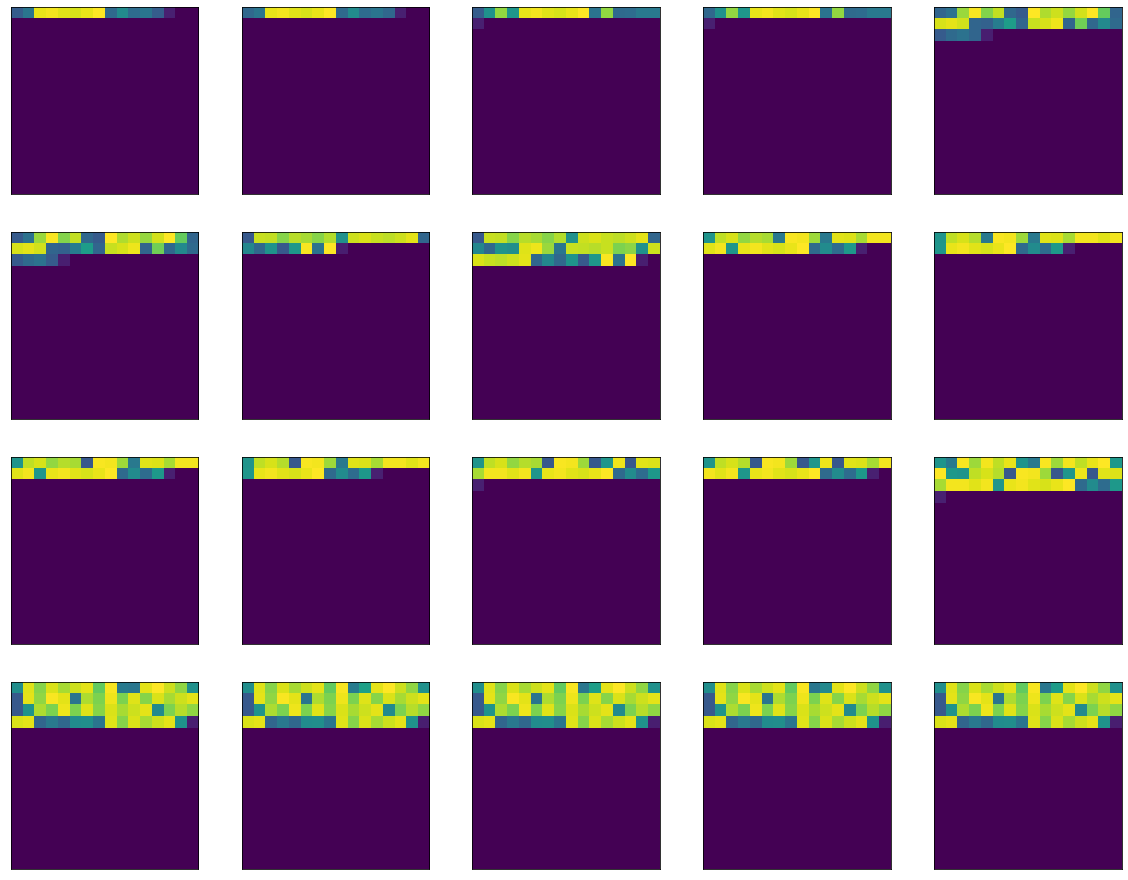

In [67]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
#     plt.imshow(training_images[i], cmap=plt.get_cmap('gray'))
    plt.imshow(training_images[i])
plt.show()


### Discriminator model
*The discriminator model performs a binary classification task which takes an image input and classifies the image as real or fake. The input size for this model will be 16x16x1 and the output will be a likelihood weather an image represents a real payload or not. The disciminator is composed of normal 2D convulational layers with stide 2x2 which is used for downsampling the input images. The model uses a dense layer with sigmoid activation function as an output since we want a likelihood output. the model uses binary_crossentropy loss function which is appropriate for binary classification tasks and also LeakyRelu instead of raw Relu. Adam optimizer is used with a learning rate of 0.0002 and momentum of 0.5.*

In [96]:
def discriminator_model(input_shape=(16, 16, 1)):
    model = Sequential()

    # Normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    # Downsampling 
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    # Downsampling 
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    # Downsampling 
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    # Classifier 
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = discriminator_model()
discriminator.summary()
# plot_model(discriminator, show_shapes=True, to_file='./images/discriminator_model.png', show_layer_names=True)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 16, 16, 64)        640       
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_149 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 4, 4, 128)       

In [97]:
# X = load_real_data('training_set.txt')
X = training_images
X.shape

(1000, 16, 16)

In [98]:
def train_discriminator(model, dataset, number_of_iteration=20, number_of_batch=128):
    half_batch = int(number_of_batch / 2)
    for i in range(number_of_iteration):
        X_real, y_real = generate_real_data(dataset, half_batch)
        _, real_accuracy = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_data(half_batch)
        _, fake_accuracy = model.train_on_batch(X_fake, y_fake)
        print(">%d real accuracy = %.0f%% fake accuracy = %.0f%% " % (i+1, real_accuracy*100, fake_accuracy*100))

In [99]:
discriminator = discriminator_model()
X = X.reshape(-1, 16, 16, 1)
# dataset = load_real_data('training_set.txt')
train_discriminator(discriminator, X)


>1 real accuracy = 41% fake accuracy = 44% 
>2 real accuracy = 77% fake accuracy = 30% 
>3 real accuracy = 88% fake accuracy = 31% 
>4 real accuracy = 98% fake accuracy = 22% 
>5 real accuracy = 98% fake accuracy = 34% 
>6 real accuracy = 98% fake accuracy = 27% 
>7 real accuracy = 100% fake accuracy = 52% 
>8 real accuracy = 98% fake accuracy = 50% 
>9 real accuracy = 100% fake accuracy = 77% 
>10 real accuracy = 100% fake accuracy = 94% 
>11 real accuracy = 100% fake accuracy = 98% 
>12 real accuracy = 100% fake accuracy = 100% 
>13 real accuracy = 100% fake accuracy = 100% 
>14 real accuracy = 100% fake accuracy = 100% 
>15 real accuracy = 100% fake accuracy = 100% 
>16 real accuracy = 100% fake accuracy = 100% 
>17 real accuracy = 98% fake accuracy = 100% 
>18 real accuracy = 98% fake accuracy = 100% 
>19 real accuracy = 97% fake accuracy = 100% 
>20 real accuracy = 97% fake accuracy = 100% 


## Generator model 
*The generator model is used for generating fake XSS payloads from randomly initlaized latent spaces. The latent spaces are random defined vector space of Gaussian-distributed values with 100 dimensions which is widely use dimension. The generator tries to generate new payloads from the initially defined latent vectors with the help of discriminator model. the input shape of the generator model is the latent space dimension in this case 100 and outputs an image with 16x16 dimension with in a range of [-1, 1]. the generator model uses Conv2dTranspose layers with 2x2 stride instead of normal Conv2D layer. This is quadruple the area of the input feater maps meaning it will increase the dimension of the images by 4. LeakyRelu is used with a default slope of 0.2 and the final Conv2D layer uses tanh activation function to make sure that the output is in range of [-1, 1].*

In [100]:
def generator_model(latent_space_dimension):
    model = Sequential()

    # start with 4 * 4 image 
    number_of_nodes = 256 * 2 * 2
    model.add(Dense(number_of_nodes, input_dim=latent_space_dimension))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((2, 2, 256)))
    # Unsample 4x4
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Unsample 8*8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Unsample 32 * 32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Output
    model.add(Conv2D(1, (3, 3), activation='tanh', padding='same'))
    return model 

latent_space_dimension = 100
generator = generator_model(latent_space_dimension)
generator.summary()
# plot_model(generator, show_shapes=True, show_layer_names=True, to_file="./images/generator_model.png")


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_156 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_51 (Conv2DT (None, 4, 4, 128)         524416    
_________________________________________________________________
batch_normalization_21 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_157 (LeakyReLU)  (None, 4, 4, 128)       

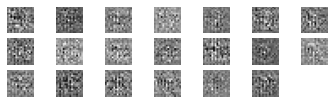

In [101]:
def generate_latent_space(latent_dimension, number_of_samples):
    x_input = np.random.randn(latent_dimension * number_of_samples)
    x_input = x_input.reshape(number_of_samples, latent_dimension)
    return x_input

def generate_fake_samples_with_generator(generator, latent_dimension, number_of_samples):
    x_input = generate_latent_space(latent_dimension, number_of_samples)
    X = generator.predict(x_input)
    y = np.zeros((number_of_samples, 1))
    return X, y 


latent_dimension = 100
generator = generator_model(latent_dimension)
number_of_samples = 20
X, _ = generate_fake_samples_with_generator(generator, latent_dimension, number_of_samples)
X = (X + 1) / 2.0
for i in range(number_of_samples):
    plt.subplot(7, 7, i + 1)
    plt.axis('off')
    plt.imshow(X[i], cmap='gray')
plt.show()


## Final GAN model
*when training GAN models the generator model is updated based on the performance of the discriminator model. When the discriminator model is capable of distinguishing real from fake well then the generator model is updated more and vis-versa. This is an adversarial form of training between the two models. To achieve this there will be a new model composed of the two models defined above the discriminator and generator model. The generator is focused on the discriminator model identifing fake images. due to this reason the discriminator model is not going when its part of the GAN model.*

In [102]:
def gan_model(generator, discriminator):
    discriminator.trainable = False 
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model 

discriminator = discriminator_model()
generator = generator_model(latent_dimension)
gan = gan_model(generator, discriminator)
gan.summary()
# plot_model(gan, show_shapes=True, show_layer_names=True, to_file='./images/gan_model.png')


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_52 (Sequential)   (None, 16, 16, 1)         1159169   
_________________________________________________________________
sequential_51 (Sequential)   (None, 1)                 518273    
Total params: 1,677,442
Trainable params: 1,156,353
Non-trainable params: 521,089
_________________________________________________________________


In [112]:
accuracy_on_fake_data_samples = []
accuracy_on_real_data_samples = []
loss_on_real_data_samples = []
loss_on_fake_data_samples = []

def save_generated_images(images, epoch, n=7):
    images = (images + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    filename = './generated_images/image_at_epoch-%03d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()

def summarize_model(epoch, generator, discriminator, dataset, latent_dimension, number_of_samples=200):
    X_real, y_real = generate_real_data(dataset, number_of_samples)
    _, real_accuracy = discriminator.evaluate(X_real, y_real, verbose=0)
    accuracy_on_real_data_samples.append(real_accuracy)
    X_fake, y_fake = generate_fake_samples_with_generator(generator, latent_dimension, number_of_samples)
    _, fake_accuracy = discriminator.evaluate(X_fake, y_fake, verbose=0)
    accuracy_on_fake_data_samples.append(fake_accuracy)
    print("Accuracy for real: %.0f%%, Accuracy for fake: %.0f%% " % (real_accuracy*100, fake_accuracy*100))
    with open("./logs/logs.txt", "a+") as logs_file:
        logs_file.write("Epoch %d Accuracy for real: %.0f%%, Accuracy for fake: %.0f%% \n" % (epoch + 1, real_accuracy*100, fake_accuracy*100))
    save_generated_images(X_fake, epoch)
    filename = './models/generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)
    return X_fake 

def train(generator, discriminator, gan, dataset, latent_dimension, number_of_epochs = 300, number_of_batches=200):
    batch_per_epoch = int(dataset.shape[0] / number_of_epochs)
    half_batch = int(number_of_batches / 2)
    generated_images = []

    for i in range(number_of_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_data(dataset, half_batch)
            discriminator_loss_1, _ = discriminator.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples_with_generator(generator, latent_dimension, half_batch)
            discriminator_loss_2, _ = discriminator.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_space(latent_dimension, number_of_batches)
            y_gan = np.ones((number_of_batches, 1))
            generator_loss = gan.train_on_batch(X_gan, y_gan)
            print("%d, %d%d, d1=%.3f, d2=%.3f, g=%.3f" % 
                (i+1, j+1, batch_per_epoch, discriminator_loss_1, discriminator_loss_2, generator_loss))  
        if (i + 1) % 10 == 0:
            images = summarize_model(i, generator, discriminator, dataset, latent_dimension)
            generated_images.append(images)
            loss_on_real_data_samples.append(discriminator_loss_1)
            loss_on_fake_data_samples.append(discriminator_loss_2)
    return generated_images


In [113]:
latent_dimension = 100
generator = generator_model(latent_dimension)
discriminator = discriminator_model()
gan = gan_model(generator, discriminator)
# dataset = load_real_data("training_set.txt")
dataset = preprocess.get_payload_matrix(os.path.join(TRAIN_DIR, "training_set.txt"))
dataset = dataset.reshape(-1, 16, 16, 1)
images = train(generator, discriminator, gan, dataset, latent_dimension)


1, 13, d1=0.695, d2=0.696, g=0.649
1, 23, d1=0.614, d2=0.697, g=0.608
1, 33, d1=0.526, d2=0.700, g=0.541
2, 13, d1=0.445, d2=0.707, g=0.443
2, 23, d1=0.339, d2=0.718, g=0.330
2, 33, d1=0.234, d2=0.733, g=0.244
3, 13, d1=0.141, d2=0.742, g=0.183
3, 23, d1=0.093, d2=0.745, g=0.150
3, 33, d1=0.054, d2=0.739, g=0.137
4, 13, d1=0.040, d2=0.726, g=0.124
4, 23, d1=0.030, d2=0.712, g=0.115
4, 33, d1=0.022, d2=0.701, g=0.121
5, 13, d1=0.017, d2=0.687, g=0.119
5, 23, d1=0.014, d2=0.672, g=0.132
5, 33, d1=0.010, d2=0.655, g=0.147
6, 13, d1=0.009, d2=0.629, g=0.174
6, 23, d1=0.009, d2=0.596, g=0.201
6, 33, d1=0.031, d2=0.558, g=0.200
7, 13, d1=0.004, d2=0.512, g=0.267
7, 23, d1=0.004, d2=0.459, g=0.352
7, 33, d1=0.004, d2=0.422, g=0.147
8, 13, d1=0.004, d2=0.361, g=0.295
8, 23, d1=0.010, d2=0.265, g=0.665
8, 33, d1=0.005, d2=0.168, g=1.541
9, 13, d1=0.529, d2=0.114, g=2.292
9, 23, d1=0.005, d2=0.077, g=3.039
9, 33, d1=0.004, d2=0.051, g=3.647
10, 13, d1=0.009, d2=0.043, g=4.248
10, 23, d1=0.017, d

74, 13, d1=0.709, d2=0.630, g=0.970
74, 23, d1=0.647, d2=0.626, g=0.999
74, 33, d1=0.713, d2=0.678, g=0.990
75, 13, d1=0.626, d2=0.604, g=1.037
75, 23, d1=0.594, d2=0.555, g=1.082
75, 33, d1=0.857, d2=0.590, g=1.035
76, 13, d1=0.501, d2=0.552, g=1.114
76, 23, d1=0.485, d2=0.500, g=1.253
76, 33, d1=1.220, d2=0.496, g=1.175
77, 13, d1=0.463, d2=0.539, g=1.226
77, 23, d1=0.463, d2=0.532, g=1.267
77, 33, d1=0.451, d2=0.537, g=1.205
78, 13, d1=0.497, d2=0.574, g=1.178
78, 23, d1=0.502, d2=0.592, g=1.063
78, 33, d1=0.568, d2=0.612, g=1.175
79, 13, d1=0.940, d2=0.609, g=1.235
79, 23, d1=0.582, d2=0.758, g=1.114
79, 33, d1=0.664, d2=1.147, g=0.885
80, 13, d1=0.721, d2=0.801, g=0.896
80, 23, d1=2.124, d2=0.666, g=0.904
80, 33, d1=0.888, d2=0.652, g=0.872
Accuracy for real: 86%, Accuracy for fake: 0% 
81, 13, d1=0.808, d2=0.661, g=0.850
81, 23, d1=0.928, d2=0.640, g=0.858
81, 33, d1=0.749, d2=0.593, g=0.890
82, 13, d1=0.704, d2=0.649, g=0.869
82, 23, d1=0.757, d2=0.640, g=0.946
82, 33, d1=0.669,

145, 33, d1=0.957, d2=0.594, g=0.989
146, 13, d1=1.349, d2=0.745, g=0.894
146, 23, d1=0.970, d2=0.755, g=0.869
146, 33, d1=0.863, d2=0.729, g=0.825
147, 13, d1=0.956, d2=0.704, g=0.861
147, 23, d1=0.935, d2=0.755, g=0.834
147, 33, d1=0.898, d2=0.749, g=0.781
148, 13, d1=0.938, d2=0.788, g=0.803
148, 23, d1=0.969, d2=0.746, g=0.744
148, 33, d1=0.980, d2=0.748, g=0.737
149, 13, d1=0.960, d2=0.724, g=0.741
149, 23, d1=1.063, d2=0.830, g=0.711
149, 33, d1=0.869, d2=0.792, g=0.750
150, 13, d1=0.840, d2=0.761, g=0.749
150, 23, d1=0.958, d2=0.747, g=0.733
150, 33, d1=0.985, d2=0.784, g=0.698
Accuracy for real: 58%, Accuracy for fake: 1% 
151, 13, d1=0.918, d2=0.777, g=0.712
151, 23, d1=1.096, d2=0.690, g=0.706
151, 33, d1=0.983, d2=0.707, g=0.698
152, 13, d1=0.917, d2=0.723, g=0.729
152, 23, d1=0.958, d2=0.727, g=0.698
152, 33, d1=0.958, d2=0.706, g=0.724
153, 13, d1=0.972, d2=0.700, g=0.717
153, 23, d1=1.151, d2=0.703, g=0.715
153, 33, d1=0.971, d2=0.682, g=0.738
154, 13, d1=0.967, d2=0.689,

216, 33, d1=0.764, d2=0.606, g=0.795
217, 13, d1=0.752, d2=0.615, g=0.792
217, 23, d1=0.782, d2=0.632, g=0.782
217, 33, d1=0.746, d2=0.650, g=0.784
218, 13, d1=0.778, d2=0.643, g=0.774
218, 23, d1=0.746, d2=0.665, g=0.758
218, 33, d1=0.761, d2=0.677, g=0.739
219, 13, d1=0.713, d2=0.683, g=0.723
219, 23, d1=0.727, d2=0.692, g=0.710
219, 33, d1=0.746, d2=0.719, g=0.718
220, 13, d1=0.718, d2=0.707, g=0.734
220, 23, d1=0.743, d2=0.686, g=0.748
220, 33, d1=0.737, d2=0.646, g=0.791
Accuracy for real: 34%, Accuracy for fake: 14% 
221, 13, d1=0.719, d2=0.620, g=0.805
221, 23, d1=0.692, d2=0.605, g=0.813
221, 33, d1=0.688, d2=0.624, g=0.821
222, 13, d1=0.847, d2=0.644, g=0.776
222, 23, d1=0.588, d2=0.715, g=0.700
222, 33, d1=0.569, d2=0.836, g=0.632
223, 13, d1=0.582, d2=0.877, g=0.627
223, 23, d1=0.631, d2=0.824, g=0.653
223, 33, d1=0.671, d2=0.774, g=0.695
224, 13, d1=0.718, d2=0.707, g=0.742
224, 23, d1=0.760, d2=0.667, g=0.762
224, 33, d1=0.760, d2=0.655, g=0.767
225, 13, d1=0.745, d2=0.660

287, 33, d1=0.137, d2=0.075, g=3.593
288, 13, d1=0.031, d2=0.202, g=3.741
288, 23, d1=0.209, d2=0.064, g=3.771
288, 33, d1=0.050, d2=0.091, g=4.144
289, 13, d1=0.037, d2=0.047, g=4.217
289, 23, d1=0.173, d2=0.044, g=3.784
289, 33, d1=0.096, d2=0.077, g=3.470
290, 13, d1=0.043, d2=0.058, g=3.666
290, 23, d1=0.074, d2=0.047, g=3.634
290, 33, d1=0.125, d2=0.078, g=3.724
Accuracy for real: 99%, Accuracy for fake: 100% 
291, 13, d1=0.028, d2=0.050, g=3.768
291, 23, d1=0.036, d2=0.031, g=3.574
291, 33, d1=0.055, d2=0.078, g=3.674
292, 13, d1=0.064, d2=0.049, g=3.709
292, 23, d1=0.059, d2=0.035, g=3.567
292, 33, d1=0.028, d2=0.050, g=3.650
293, 13, d1=0.078, d2=0.039, g=3.738
293, 23, d1=0.040, d2=0.036, g=3.556
293, 33, d1=0.055, d2=0.027, g=3.434
294, 13, d1=0.054, d2=0.031, g=3.406
294, 23, d1=0.116, d2=0.053, g=3.293
294, 33, d1=0.100, d2=0.036, g=3.210
295, 13, d1=0.029, d2=0.037, g=3.309
295, 23, d1=0.051, d2=0.066, g=3.320
295, 33, d1=0.045, d2=0.043, g=3.270
296, 13, d1=0.072, d2=0.08

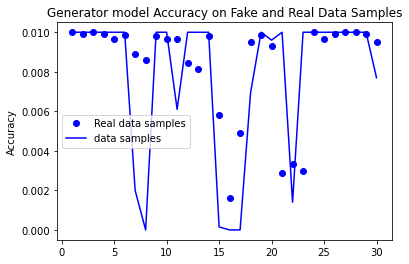

In [114]:
for i in range(len(accuracy_on_fake_data_samples)):
    accuracy_on_fake_data_samples[i] /= 100.0
    accuracy_on_real_data_samples[i] /= 100.0

# Plot generator accuracy on fake and real data samples 
epochs = range(1, len(accuracy_on_real_data_samples) + 1)
plt.plot(epochs, accuracy_on_real_data_samples, 'bo', label='Real data samples')
plt.plot(epochs, accuracy_on_fake_data_samples, 'b', label='data samples')
plt.title("Generator model Accuracy on Fake and Real Data Samples")
plt.ylabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

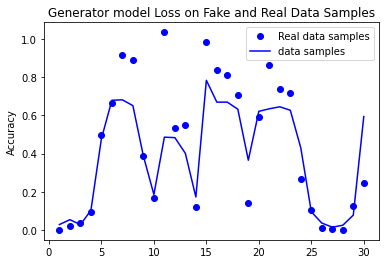

In [115]:
# Plot generator accuracy on fake and real data samples 
epochs = range(1, len(accuracy_on_real_data_samples) + 1)
plt.plot(epochs, loss_on_real_data_samples, 'bo', label='Real data samples')
plt.plot(epochs, loss_on_fake_data_samples, 'b', label='data samples')
plt.title("Generator model Loss on Fake and Real Data Samples")
plt.ylabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [116]:
def convert_ascii_to_char(payload_ascii):
    return ''.join(map(chr, payload_ascii))


def revert_image_to_ascii(image):
#     image = np.uint8(image * 255)
    image = np.uint8(np.round((image + 1) * 255 / 2))
    image = image.flatten().tolist()
    image = [ascii for ascii in image if ascii >= 33 and ascii <= 126]
    return image


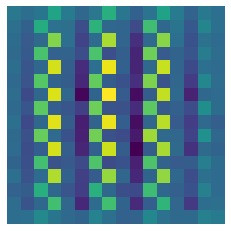

-0.66557354 0.79204637


In [117]:
images_1 = images[0]
plt.imshow(images_1[0])
plt.axis('off')
plt.show()
print(np.min(images_1[0]), np.max(images_1[0]))


In [118]:
image_1 = convert_ascii_to_char(revert_image_to_ascii(images_1[0]))
image_1


'umsxittdrwfunodpoWigUjr^om`knQlgDjnYpkk_efVXc>`f\\zmn\\icBnd>kgUolj\\fb?bYD[hLmmThh-ga1aj<jlj\\b]N[YB_cVloTjb:fb2h`MjckYlY<YV8khPikXbc>da+bkFkfgXZ_UUZ;f`bzlnZldN`h@fiWokebi\\LiWTicY|lm[jh@lfAbhJnpnosjg}oefqkk|w'

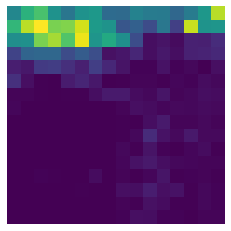

In [119]:
images_20 = images[19]
image_19 = images_20[-1]

plt.imshow(image_19)
plt.axis('off')
plt.show()

In [120]:
image_19 = convert_ascii_to_char(revert_image_to_ascii(image_19))
image_19

'Ss[G[_>>PKJ<J_va\\07*G"\\]YZ]mY*$:<;*4+!!'

In [121]:
payloads_from_last_batch = []
for image in images_20:
    payloads_from_last_batch.append(
        convert_ascii_to_char(revert_image_to_ascii(image)))
payloads_from_last_batch


["GtvYC[[<@OIJ;J_{qQ(3)AhknfrlM+%573%/*'",
 "TV7Xa:>GGJ=LccO&/'4qkaVzwh1*34$%#",
 'Sxs6b^87SJK5KbqP\')!3ro]]m~o("',
 "U\\'V_.6HBH9Ifk^E.xyWia~$%",
 'NwW=cd;<NGD:MZ}lZ+/*6#`b]Xnlh+!&.3,',
 'Uum8]f=9K@H2HaK)&%2mpVks*(',
 'Syc;^c7<OFE6EaknX)\'#<rnmLfxqrl4"',
 "Lp^>Ud;CTKH?JWu_X76':(g`WUvtb5$9A4++)'",
 'CzuWNQUILNNT=OW``W;E6@(ZU9T^y~|\\`V,"7:3#0#0',
 'U}bB[gE?OHJ:Mayzb5;%6bYjdpng2823!,+',
 '[y~bCYc;<PLD7C]qP-,&:aijR}7$*',
 "GryUC\\]<KLDD>V_qdO.63B'baOMusoZ7372,2.$$&",
 'Sv\\2]_=AMKI<I`tdQ25$0kbY^v7-%!',
 "Jp}WEL^ADKJU>HaoeV*8(N'bb[[ahX/'C=5;53!)",
 "Frta5Wa=>PEB6B^fN)8'9a]c\\zxsb9%$",
 'KyylE`YDEJNOAO\\weY2;1F,P^S`loif.1#%!',
 "bUAc\\>=HGG>P]}vlP,0(:#gk]M{tean/'#$!",
 'Za4_b/7GBA8Fa`O#&-u}Mmm+)#!',
 'Ob>[k9@RMM8FYyiO-.&;!fomkt2#-5$"-(',
 '\\q]?^[=:MED6?_pT!.4noPy|,$!',
 'Hq^?Yc7@FCC>E`zeX*4&9$XWcbgt\\4&FBC68("(',
 'T}j2_g38MBF6Oe}{@%7~~Wqzk),',
 'IZC[^CINLP@KVhfP8>4R0QT?Qi_J)2:8%9:)%',
 'Jw^LW[BEKKJ?M]prS7;-A$_^NflrsZ7,*&"2.',
 "Lq{ZAXa=@NFL@I`xe]17,8%a\\UWzuvm/574'9)$!",
 'V|b;VZ59LDG<Cdk